# Evaluating Agentic App developed using Langgraph: Advanced Capabilities with IBM watsonx.governance

This notebook demonstrates advanced evaluation capabilities of IBM watsonx.governance for monitoring and governing production-grade LangGraph agentic systems. Using an Agentic RAG implementation that orchestrates OpenAI's `gpt-4o-mini` and `text-embedding-3-small` through LangGraph workflows, we showcase how to use different evaluators in development environment. These evaluators provide enterprise-ready governance for complex agentic architectures, moving beyond basic LLM assessments.


### Install the dependencies

In [ ]:
%pip install --quiet "ibm-watsonx-gov[agentic]" langchain-chroma langchain-openai tavily-python pyppeteer nest_asyncio

### Accept the credentials
The following code snippet ensures that specific environment variables are set without being hardcoded in the script. It does so by prompting the user for input only if the variables are not already set.

The environment variables need to be set are:

1. **OPENAI_API_KEY:** This is required for Open AI capabilities.
2. **WXG_API_KEY:** This is required for IBM watsonx.governance capabilities.
3. **TAVILY_API_KEY:** This is required for web search capabilities

Optionally, if you are using IBM watsonx.governance as a service in a regional data center other than **Dallas (us-south), in Texas US**, you need to set  **WXG_URL**. You can check the regional availability of the watsonx services [here](https://www.ibm.com/docs/en/watsonx/saas?topic=integrations-regional-availability-cloud#regional-availability-of-the-watsonx-services)

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("WXG_API_KEY")
_set_env("TAVILY_API_KEY")

### Set up the local vector store

We have created a local vector store comprising of a few medium posts by [Manish Bhide](https://medium.com/@manish.bhide) and [Ravi Chamarthy](https://medium.com/@ravi-chamarthy). These posts focus on the various capabilities in IBM watsonx.governance (and erstwhile IBM Watson OpenScale). Hence, our queries will focus on these capabilities covered in the above posts. 

For user's convenience, the vector store has been compressed. The following cell downloads the compressed file, extracts it locally, and initializes the Chroma store. 

In [2]:
%rm medium_db.zip
%rm -r medium_db/

!wget https://github.com/IBM/ibm-watsonx-gov/raw/refs/heads/samples/notebooks/data/agentic/medium_db.zip

--2025-03-25 22:48:58--  https://github.com/IBM/ibm-watsonx-gov/raw/refs/heads/samples/notebooks/data/agentic/medium_db.zip
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/ibm-watsonx-gov/refs/heads/samples/notebooks/data/agentic/medium_db.zip [following]
--2025-03-25 22:48:58--  https://raw.githubusercontent.com/IBM/ibm-watsonx-gov/refs/heads/samples/notebooks/data/agentic/medium_db.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 1203223 (1.1M) [application/zip]
Saving to: ‘medium_db.zip’

medium_db.zip       100%[===================>]   1.15M  1.94MB/s    in 0.6s    

2025-03-25 22:49:00 (1.94 M

In [3]:
import zipfile

with zipfile.ZipFile("medium_db.zip", "r") as zip_ref:
    zip_ref.extractall(".")

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

openai_embed_model = OpenAIEmbeddings(model="text-embedding-3-small")

vector_store = Chroma(
    collection_name="medium_articles",
    embedding_function=openai_embed_model,
    persist_directory="./medium_db"
)

### Set up the State

In [5]:
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        input_text (str): 
            The user's raw input query or question. 
        ground_truth (Optional[str]): 
            Reference/correct answer (if available). Used for evaluation.  
        record_id (Optional[str]): 
            Unique identifier for the record.            
        local_context (List[str]): 
            Context retrieved from local knowledge base or vector store. 
        web_context (List[str]): 
            Context fetched from web searches (if used). 
        generated_text (Optional[str]): 
            The final output generated by the LLM after processing all contexts.
    """
    input_text: str #The user's raw input query or question
    ground_truth: str #Reference/correct answer (if available). Used for evaluation
    record_id: str #Unique identifier for the record
    local_context: list[str] #Context retrieved from vector store
    web_context: list[str] #Context fetched from web searches (if used)
    generated_text: str #The final output generated by the LLM after processing all contexts

### Set up the evaluator

For evaluating your Agentic AI applications, you need to first instantiate the `AgenticEvaluation` class. This class defines a few evaluators to compute the different metrics.

We are going to use the following evaluators in this notebook:
1. `evaluate_context_relevance` : To compute context relevance metric of your content retrieval tool.
2. `evaluate_faithfulness`: To compute faithfulness metric of your answer generation tool. This metric does not require ground truth.
3. `evaluate_answer_similarity`: To compute answer similarity metric of your answer generation tool. This metric requires ground truth for computation.

#### Configuring Evaluations

Users can define evaluation configurations by specifying relevant fields for different evaluation types, such as context relevance, answer similarity, and faithfulness.  

For example, a configuration for evaluating context relevance might look like this:  

```python
context_relevance_config = {
    "question_field": "input_text", 
    "context_fields": ["local_context"], 
    "record_id_field": "record_id", 
}
```

This configuration is then used to create an `AgenticAIConfiguration` instance.

Users can also override the threshold value for each metric by passing a `MetricThreshold` parameter. For example, setting a lower limit threshold for context relevance can be done as follows:

```python
@evaluator.evaluate_context_relevance(
    configuration=AgenticAIConfiguration(**context_relevance_config),
    metrics=[ContextRelevanceMetric(
        thresholds=[MetricThreshold(type="lower_limit", value=0.7)]
    )]
)
def my_node_function(input_text, local_context, record_id):
    # Node processing logic here
    pass
```

In [6]:
from ibm_watsonx_gov.evaluate.agentic_evaluation import AgenticEvaluation

evaluator = AgenticEvaluation()

### Build your langgraph application

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.config import RunnableConfig

#### Define vector database retrieval node

We are using a Similarity with Threshold Retrieval strategy. This will fetch the top 3 documents matching the query if the threshold score is more than 0.1

The `local_search_node` tool defined below is decorated with IBM watsonx.governance evaluator `evaluate_context_relevance` tool to compute the context relevance metric. This node reads the user query from the `input_text` attribute from the application state and writes the result into the `local_context` attribute back to the application state.

In [8]:
from ibm_watsonx_gov.metrics import ContextRelevanceMetric
from ibm_watsonx_gov.entities.metric import MetricThreshold
from ibm_watsonx_gov.config import AgenticAIConfiguration

In [9]:
context_relevance_config={
    "question_field": "input_text", 
    "context_fields": ["local_context"], 
    "record_id_field": "record_id", 
}

@evaluator.evaluate_context_relevance(configuration=AgenticAIConfiguration(**context_relevance_config), metrics=[
    ContextRelevanceMetric(thresholds=[MetricThreshold(
        type="lower_limit", value=0.7)])])
def local_search_node(state: GraphState, config: RunnableConfig):
    similarity_threshold_retriever = vector_store.as_retriever(search_type="similarity_score_threshold",
                                                               search_kwargs={"k": 3,
                                                                              "score_threshold": 0.1})
    context = similarity_threshold_retriever.invoke(state["input_text"])
    return {
        "local_context": [doc.page_content for doc in context]
    }

#### Define web search retrieval node

We are using a Tavily to do the web search.

The `web_search_node` tool defined below is decorated with IBM watsonx.governance evaluator `evaluate_context_relevance` tool to compute the context relevance metric. This node reads the user query from the `input_text` attribute from the application state and writes the result into the `web_context` attribute back to the application state.

In [10]:
# Initialize Tavily client (Get your API key at https://tavily.com/)
from tavily import TavilyClient
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
tavily = TavilyClient(api_key=TAVILY_API_KEY)

context_relevance_config={
    "question_field": "input_text", 
    "context_fields": ["web_context"], 
    "record_id_field": "record_id", 
}


@evaluator.evaluate_context_relevance(configuration=AgenticAIConfiguration(**context_relevance_config), metrics=[
    ContextRelevanceMetric(thresholds=[MetricThreshold(
        type="lower_limit", value=0.7)])])
def web_search_node(state: GraphState, max_results: int = 5) -> list[str]:
    """Perform web search and return relevant content snippets"""
    search_result = tavily.search(
        query=state["input_text"],
        search_depth="basic",  # or "advanced" for deeper search
        max_results=max_results,
        include_answer=True,
        include_raw_content=False
    )
    
    # Process results with priority to answer if available
    results = []
    if search_result.get("answer"):
        results.append(f"Direct answer: {search_result['answer']}")
    
    # Add relevant context from top results
    for result in search_result.get("results", [])[:max_results]:
        if content := result.get("content"):
            results.append(f"From {result['url']}: {content}")
    
    return {
        "web_context": results[:max_results]
    }

#### Define vector-database based answer generation tool

We are using `gpt-4o-mini` to generate an answer for our query.

The `generate_local_context_node` defined below is decorated with two evaluators `evaluate_faithfulness` and `evaluate_answer_similarity` for computing answer quality metrics. Like in the previous cell, this node reads the user query from the `input_text` attribute from the application state, the `context` attribute consists of the context chunks. After generating the answer, the node writes the result into the `generated_text` attribute back to the application state.

In [11]:
answer_relevance_config={
    "question_field": "input_text", 
    "context_fields": ["local_context"], 
    "record_id_field": "record_id", 
    "output_fields": ["generated_text"],
    "reference_fields":["ground_truth"]
}

faithfulness_config={
    "question_field": "input_text", 
    "context_fields": ["local_context"], 
    "record_id_field": "record_id", 
    "output_fields": ["generated_text"],
}

@evaluator.evaluate_answer_similarity(configuration=AgenticAIConfiguration(**answer_relevance_config))
@evaluator.evaluate_faithfulness(configuration=AgenticAIConfiguration(**faithfulness_config))
def generate_local_context_node(state: GraphState, config: RunnableConfig):
    generate_prompt = ChatPromptTemplate.from_template(
        "Answer the query using only the provided context:\n"
        "Context: {context}\n"
        "Question: {input_text}\n"
        "Answer:"
    )

    formatted_prompt = generate_prompt.invoke(
        {"input_text": state["input_text"], "context": "\n".join(state["local_context"])})
    llm = ChatOpenAI(model="gpt-4o-mini")
    result = llm.invoke(formatted_prompt)
    return {
        "generated_text": result.content
    }

#### Define web-search based answer generation tool

We are using `gpt-4o-mini` to generate an answer for our query.

The `generate_web_context_node` defined below is decorated with two evaluators `evaluate_faithfulness` and `evaluate_answer_similarity` for computing answer quality metrics. Like in the previous cell, this node reads the user query from the `input_text` attribute from the application state, the `context` attribute consists of the context chunks. After generating the answer, the node writes the result into the `generated_text` attribute back to the application state.

In [12]:
answer_relevance_config={
    "question_field": "input_text", 
    "context_fields": ["web_context"], 
    "record_id_field": "record_id", 
    "output_fields": ["generated_text"],
    "reference_fields":["ground_truth"]
}

faithfulness_config={
    "question_field": "input_text", 
    "context_fields": ["web_context"], 
    "record_id_field": "record_id", 
    "output_fields": ["generated_text"],
}

@evaluator.evaluate_answer_similarity(configuration=AgenticAIConfiguration(**answer_relevance_config))
@evaluator.evaluate_faithfulness(configuration=AgenticAIConfiguration(**faithfulness_config))
def generate_web_context_node(state: GraphState, config: RunnableConfig):
    generate_prompt = ChatPromptTemplate.from_template(
        "Answer the query using web-sourced information:\n"
        "Context: {context}\n"
        "Question: {input_text}\n"
        "Answer:"
    )

    formatted_prompt = generate_prompt.invoke(
        {"input_text": state["input_text"], "context": "\n".join(state["web_context"])})
    llm = ChatOpenAI(model="gpt-4o-mini")
    result = llm.invoke(formatted_prompt)
    return {
        "generated_text": result.content
    }

#### Adding a Router Function to Check Context Relevance

- The `check_context_relevance` function evaluates the retrieved context and assigns a **Context Relevance Score**.  
- If the score meets the required threshold, the workflow proceeds to the **Vector DB Answer Generation** node.  
- If the score is below the threshold, the workflow reroutes to the **Web Search Node** for additional information.  

In [13]:
def check_context_relevance(state: GraphState, config: RunnableConfig):
    metrics = evaluator.get_metric_results()
    
    # Filter results for "context_relevance" from the "retrieval_node"
    relevant_metrics = [
        m for m in metrics 
        if m.name == "context_relevance" 
    ]
    if not relevant_metrics:
        # Default to "no" if no metrics found
        return "Context Relevance \nScore is Bad"
    
    # Get the latest metric (assuming last entry is most recent)
    latest_metric = relevant_metrics[-1]
    
    # Check if context relevance is below threshold
    if latest_metric.value > 0.5:
        return "Context Relevance \nScore is Good"
    else:
        return "Context Relevance \nScore is Bad"

#### Assemble your application

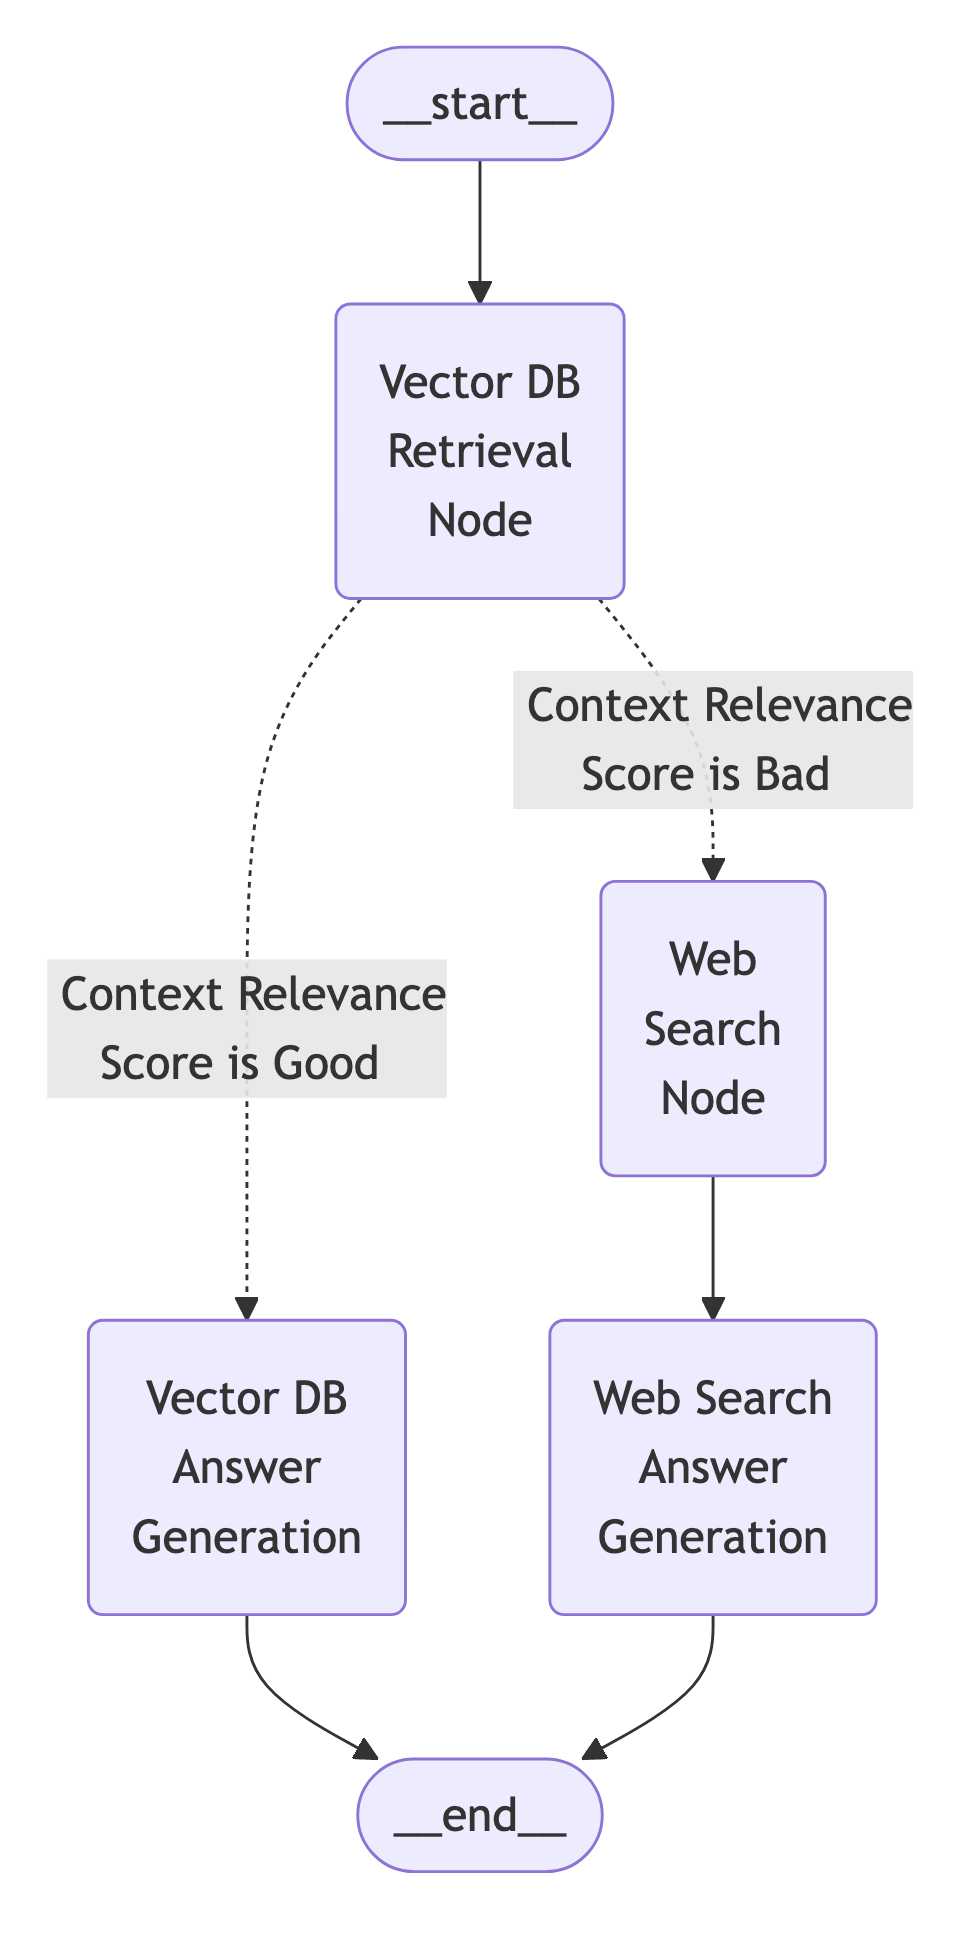

In [14]:
from langgraph.graph import START, END, StateGraph

graph = StateGraph(GraphState)

# Add nodes
graph.add_node("Vector DB \nRetrieval \nNode", local_search_node)
graph.add_node("Web \nSearch \nNode", web_search_node)
graph.add_node("Vector DB \nAnswer \nGeneration", generate_local_context_node)
graph.add_node("Web Search \nAnswer \nGeneration", generate_web_context_node)

# Add edges
graph.add_edge(START, "Vector DB \nRetrieval \nNode")
graph.add_conditional_edges(
    "Vector DB \nRetrieval \nNode",
    check_context_relevance,
    {
        "Context Relevance \nScore is Good": "Vector DB \nAnswer \nGeneration",
        "Context Relevance \nScore is Bad": "Web \nSearch \nNode",
    },
)
graph.add_edge("Web \nSearch \nNode", "Web Search \nAnswer \nGeneration")
graph.add_edge("Vector DB \nAnswer \nGeneration", END)
graph.add_edge("Web Search \nAnswer \nGeneration", END)

# Compile the graph
rag_app = graph.compile()

# Show
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        rag_app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.NATURAL,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=5,
        ),
        width=300,  # Image width in pixels
        height=200  # Image height in pixels
    )
)

### Do a single invocation

Now the application is invoked for a single row of data. You will see two new keys as the input:
1. `ground_truth`: As the name suggests, this attribute holds the ground truth for your input text. This is needed for the answer similarity metric, which is a reference based metric. For the other metrics, this is not required.
2. `record_id`: This is required so that IBM watsonx.governance can keep track of individual rows and associate metrics with each row. This will become evident when we do batch invocation in the next cell.

In [15]:
result = rag_app.invoke({"input_text": "What is concept drift?", "ground_truth": "Concept drift occurs when the statistical properties of the target variable change over time, causing a machine learning model’s predictions to become less accurate.", "record_id":"764546"})

In [22]:
def transform_to_wide_format(df):
    """Convert the metrics dataframe into wide format"""
    df["idx"] = df.apply(
        lambda row: f"{row['tool_name']}.{row['name']}", axis=1
    )
    
    # Pivot the table
    df_wide = df.pivot_table(
        index="record_id",
        columns="idx",
        values="value"
    ).reset_index().rename_axis("", axis=1)
    
    return df_wide

transform_to_wide_format(evaluator.get_metrics_df())

### Invoke the graph on multiple rows

IBM watsonx.governance evaluation of Agentic Applications can be done with batch invocation too. Here, a dataframe with questions and ground truths for those questions have been defined. The dataframe index has been used as  `record_id` to uniquely identify each row. 

In [17]:
import pandas as pd

question_bank_df = pd.read_csv("https://raw.githubusercontent.com/IBM/ibm-watsonx-gov/refs/heads/samples/notebooks/data/agentic/watsonx_governance_question_bank.csv")
question_bank_df["record_id"] = question_bank_df.index.astype(str)
question_bank_df

,input_text,ground_truth,record_id
0,"To run Watson OpenScale on my own servers, how...",There are specific guidelines for hardware con...,0
1,Why does Watson OpenScale need access to train...,Watson OpenScale needs access to training data...,1
2,Is there a command-line tool to use with Watso...,"Yes, there is a ModelOps CLI tool called Watso...",2
3,What version of Python can I use with Watson O...,Watson OpenScale is independent of your model-...,3
4,Which browsers can I use to run Watson OpenScale?,Watson OpenScale service tooling requires the ...,4
...,...,...,...
95,Can data marts be shared across teams?,"Yes, if they have access to the workspace.",95
96,Is debiasing always automatic?,"No, it can require manual intervention.",96
97,Can deployments be updated without downtime?,"Yes, depending on the platform's capabilities.",97
98,Is drift always negative?,"Yes, it signals declining model performance.",98


In [20]:
result = rag_app.batch(inputs=question_bank_df.to_dict("records"))

In [23]:
transform_to_wide_format(evaluator.get_metrics_df())

,record_id,generate_local_context_node.answer_similarity,generate_local_context_node.faithfulness,generate_local_context_node.tool_latency (s),generate_web_context_node.answer_similarity,generate_web_context_node.faithfulness,generate_web_context_node.tool_latency (s),local_search_node.context_relevance,local_search_node.tool_latency (s),web_search_node.context_relevance,web_search_node.tool_latency (s)
0,0,0.320458,0.558295,1.115732,NaN,NaN,NaN,0.525622,0.988993,NaN,NaN
1,1,0.827687,0.519092,1.288751,NaN,NaN,NaN,0.551292,0.654694,NaN,NaN
2,10,0.679846,0.503575,2.119993,NaN,NaN,NaN,0.402242,0.923560,NaN,NaN
3,11,0.917342,0.629128,1.463488,NaN,NaN,NaN,0.575395,0.894260,NaN,NaN
4,12,0.601226,0.581792,1.476930,NaN,NaN,NaN,0.497263,0.820177,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
96,95,NaN,NaN,NaN,0.355105,0.942488,1.611778,0.357016,0.476610,0.877668,3.058220
97,96,NaN,NaN,NaN,0.418275,0.891576,0.933592,0.366435,0.445172,0.881450,3.668937
98,97,NaN,NaN,NaN,0.239519,0.979002,1.340387,0.313183,0.398141,0.794290,3.452654
99,98,NaN,NaN,NaN,0.285834,0.945012,1.505671,0.100447,0.515364,0.869842,2.798999


Developed by [Salman Khan S](https://ibm.enterprise.slack.com/team/U05N5D76GQL)